In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import and Reshape Data

In [9]:
df = pd.read_csv('transactions_n100000.csv')

In [10]:
df.head()

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x7901ee,2019-01-16 18:33:00,7,shake,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,burger,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,fries,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salad,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,fries,1,41.884490,-87.627059


In [11]:
df.shape

(260645, 7)

In [12]:
#Separately get data grouped by ticket_id with their order timestamps and location data, and the other with item names and counts, and merge them together
grouped_df = df.groupby(by='ticket_id').first().drop(['item_name','item_count'],axis=1)
item_types = pd.pivot_table(df,index='ticket_id',columns='item_name',values='item_count').fillna(0)

new_df = grouped_df.merge(item_types,left_on='ticket_id',right_on='ticket_id')

In [13]:
new_df.head()

,order_timestamp,location,lat,long,burger,fries,salad,shake
ticket_id,,,,,,,,
0x10000a,2019-01-29 00:48:00,9,41.524598,-87.849468,1.0,1.0,0.0,0.0
0x100058,2019-05-05 00:08:00,6,41.784576,-87.607565,2.0,2.0,0.0,0.0
0x1000c8,2019-01-28 19:24:00,9,41.524598,-87.849468,4.0,5.0,1.0,4.0
0x10014c,2019-02-23 00:15:00,6,41.784576,-87.607565,1.0,1.0,0.0,0.0
0x1001d8,2019-06-30 17:50:00,2,42.049306,-87.677606,3.0,3.0,0.0,3.0


In [14]:
new_df.shape

(100000, 8)

## Feature Engineering

In [15]:
new_df['order_timestamp'] = pd.to_datetime(new_df['order_timestamp'])
new_df['hour'] = new_df['order_timestamp'].dt.hour
new_df['day_of_week'] = new_df['order_timestamp'].dt.dayofweek

In [16]:
new_df = new_df.drop(['lat','long','order_timestamp'],axis=1)

In [17]:
#Based on Tableau Analytics:

def classify_location(loc):
    if loc in [1,3,5,8]:
        label = 'Chicago_City'
        #loc 8 is in Chicago prime location - Magnificent Mile
        #loc 5 is close to the central train station
    elif loc in [2,6]:
        label = 'University'
        #specifically, location 2 is near Northwestern, 6 is near UChic
    else:
        label = 'Suburban'
    return label

def classify_day_of_week(day):
    if day <= 4:
        label = 'weekday'
    else:
        label = 'weekend'
    return label

def classify_time_of_day(time):
    if (time >= 6) and (time <= 10):
        #6am-10am
        label = 'morning'
    elif (time >= 10) and (time <= 16):
        #10am- 4pm
        label = 'afternoon'
    elif (time >= 16) and (time <= 21):
        #4pm-9pm
        label = 'evening'
    else:
        #9pm-4am
        label = 'late_night'
    return label

In [18]:
#new_df['location_type'] = new_df.location.apply(classify_location) decided not to use these labels as want to see if clustering algo picked it up for us
new_df['week_day'] = new_df.day_of_week.apply(classify_day_of_week)
new_df['time_of_day'] = new_df.hour.apply(classify_time_of_day)

new_df = new_df.drop(['day_of_week','hour'],axis=1)

In [19]:
new_df.head()

,location,burger,fries,salad,shake,week_day,time_of_day
ticket_id,,,,,,,
0x10000a,9,1.0,1.0,0.0,0.0,weekday,late_night
0x100058,6,2.0,2.0,0.0,0.0,weekend,late_night
0x1000c8,9,4.0,5.0,1.0,4.0,weekday,evening
0x10014c,6,1.0,1.0,0.0,0.0,weekend,late_night
0x1001d8,2,3.0,3.0,0.0,3.0,weekend,evening


In [20]:
#One Hot Encoding using get_dummies

list_of_cols = ['location','week_day','time_of_day']

for var in list_of_cols:
    cat_list = pd.get_dummies(new_df[var])
    new_df = new_df.join(cat_list)

new_df = new_df.drop(list_of_cols,axis=1)

In [21]:
new_df.head()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,weekday,weekend,afternoon,evening,late_night
ticket_id,,,,,,,,,,,,,,,,,,
0x10000a,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
0x100058,2.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
0x1000c8,4.0,5.0,1.0,4.0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
0x10014c,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
0x1001d8,3.0,3.0,0.0,3.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [22]:
#Ran the first time, found that weekday/weekend split not impt, so im removing it

new_df.drop(['weekday','weekend'],axis=1,inplace=True)

## Train-Test Split and Standardization

In [23]:
from sklearn import model_selection

train,test = model_selection.train_test_split(new_df, test_size=0.3, random_state = 0)

In [24]:
from sklearn import preprocessing

In [25]:
#Use Min-max Scaler to scale data

Scaler = preprocessing.MinMaxScaler()
train_scaled = Scaler.fit_transform(train)
test_scaled = Scaler.transform(test)

train_scaled = pd.DataFrame(train_scaled, columns = train.columns,index= train.index)
test_scaled = pd.DataFrame(test_scaled,columns = test.columns,index= test.index)

In [26]:
# Try with the standard scaler instead of Min-Max Scaler

Std_Scale = preprocessing.StandardScaler()
train_std_scaled = Std_Scale.fit_transform(train)
test_std_scaled = Std_Scale.transform(test)

train_std_scaled = pd.DataFrame(train_std_scaled, columns = train.columns,index= train.index)
test_std_scaled = pd.DataFrame(test_std_scaled,columns = test.columns,index= test.index)

## Clustering

In [27]:
from sklearn.cluster import KMeans

In [28]:
#Cluster with min-max scaled data
kmeans = KMeans(n_clusters=3, random_state=0).fit(train_scaled)

In [29]:
columns = train_scaled.columns
centers = kmeans.cluster_centers_

pd.DataFrame(data=centers,columns=columns)

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
0,0.680385,0.655794,0.044250,0.643650,0.034538,0.029553,0.035817,0.260553,0.035640,0.031229,0.266111,0.043668,0.262891,8.557188e-03,9.914428e-01,-1.763034e-13
1,0.100325,0.330067,0.363729,0.055336,0.189044,0.040757,0.186932,0.055243,0.190100,0.041982,0.053385,0.189002,0.053554,1.000000e+00,-6.900036e-14,-1.865175e-13
2,0.348520,0.203112,0.013969,0.064096,0.031625,0.394216,0.034035,0.030272,0.022704,0.393540,0.030611,0.032133,0.030864,-1.587619e-13,-6.900036e-14,1.000000e+00


In [30]:
#Proportion of clusters on train data
labels = pd.DataFrame(data= kmeans.labels_)
print(labels[0].value_counts(normalize=True))

1    0.338243
2    0.337886
0    0.323871
Name: 0, dtype: float64


In [31]:
#Cluster with normalized scaled data

kmeans_std = KMeans(n_clusters=3, random_state=0).fit(train_std_scaled)

labels = pd.DataFrame(data= kmeans_std.labels_)
print(labels[0].value_counts(normalize=True))

0    0.335671
1    0.335243
2    0.329086
Name: 0, dtype: float64


## Validation

In [32]:
#plotting elbow graph, using normalized scaled data
Sum_of_squared_distances = []
K = range(1,10)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train_std_scaled)
    Sum_of_squared_distances.append(km.inertia_)

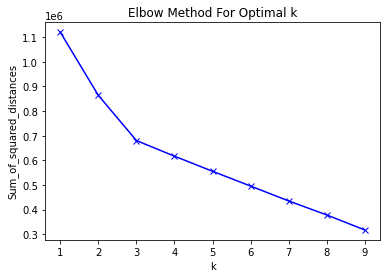

In [33]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [34]:
#Look at proportion of clusters on test data
labels = pd.DataFrame(data= kmeans_std.predict(test_std_scaled))
labels[0].value_counts(normalize=True)

0    0.338567
1    0.338133
2    0.323300
Name: 0, dtype: float64

## Looking at the Mean Characteristics

In [35]:
#Transform min-max scaled data back
transformed = Scaler.inverse_transform(train_scaled)

train_scaled_transformed = pd.DataFrame(transformed, columns = train.columns,index= train.index)

#Putting Labels back into DF
train_scaled_transformed['cluster_labels'] = kmeans.labels_

In [36]:
train_scaled_transformed.groupby(by='cluster_labels').mean()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
cluster_labels,,,,,,,,,,,,,,,,
0,3.401923,3.623175,0.221252,3.218252,0.034538,0.029553,0.035817,0.260553,0.035640,0.031229,0.266111,0.043668,0.262891,0.008557,0.991443,0.0
1,0.501626,2.320269,1.818643,0.276682,0.189044,0.040757,0.186932,0.055243,0.190100,0.041982,0.053385,0.189002,0.053554,1.000000,0.000000,0.0
2,1.742601,1.812447,0.069846,0.320480,0.031625,0.394216,0.034035,0.030272,0.022704,0.393540,0.030611,0.032133,0.030864,0.000000,0.000000,1.0


In [39]:
#Transform normalized scaled data back
transformed = Std_Scale.inverse_transform(train_std_scaled)

train_scaled_transformed = pd.DataFrame(transformed, columns = train.columns,index= train.index)

#Putting Labels back into DF
train_scaled_transformed['cluster_labels'] = kmeans_std.labels_

In [40]:
train_scaled_transformed.groupby(by='cluster_labels').mean()

,burger,fries,salad,shake,1,2,3,4,5,6,7,8,9,afternoon,evening,late_night
cluster_labels,,,,,,,,,,,,,,,,
0,1.732051,1.782908,0.050858,0.320296,0.029408,0.400519,0.032345,0.028897,0.020726,0.400051,0.028812,0.030515,0.028727,0.001915,0.005873,0.992212
1,0.356415,2.247539,1.891124,0.135893,0.198619,0.039204,0.195594,0.044573,0.198108,0.040056,0.043124,0.198577,0.042144,0.964248,0.028039,0.007713
2,3.523007,3.703334,0.180326,3.315550,0.028434,0.027262,0.030083,0.269404,0.030821,0.029085,0.274874,0.036812,0.273225,0.052006,0.941179,0.006815


In [41]:
#Both ways of standardizing yield quite similar results, maybe min-max is better in splitting the times of the day